Packages

In [1]:
from catboost import CatBoostClassifier
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns
import xgboost as xgb

from collections import Counter
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split

**Données**

In [2]:
# Chemins
os.chdir("D:/Home/legachet/OneDrive - Université de Rennes/école/machine learning aprofondissement/projet FI")

path_x_train = 'data/X_train_G3tdtEn.csv'
path_y_train = 'data/Y_train_2_XPXJDyy.csv'
path_x_test  = 'data/X_test_8skS2ey.csv'

# Chargement des données
df_x_train = pd.read_csv(path_x_train)
df_y_train = pd.read_csv(path_y_train)
df_x_test  = pd.read_csv(path_x_test)

# Vérification des dimensions avant fusion
print(f"Dimensions X_train : {df_x_train.shape}")
print(f"Dimensions Y_train : {df_y_train.shape}")

C:\Users\legachet\AppData\Local\Temp\ipykernel_4080\3329415586.py:9: DtypeWarning: Columns (21,22,23,24,69,70,71,72,93,94,95,96,97,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120) have mixed types. Specify dtype option on import or set low_memory=False.
  df_x_train = pd.read_csv(path_x_train)


Dimensions X_train : (92790, 146)
Dimensions Y_train : (92790, 3)


C:\Users\legachet\AppData\Local\Temp\ipykernel_4080\3329415586.py:11: DtypeWarning: Columns (20,21,22,23,24,68,69,70,71,72,92,93,94,95,96,97,106,107,108,109,110,111,112,113,114,115,116,117,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df_x_test  = pd.read_csv(path_x_test)


In [3]:
# Fusion de X et Y
df_train = pd.merge(df_x_train, df_y_train, on='ID', how='inner')

print(f"Dimensions après fusion : {df_train.shape}")

display(df_train.head(10))


Dimensions après fusion : (92790, 148)


,ID,item1,item2,item3,item4,item5,item6,item7,item8,item9,...,Nbr_of_prod_purchas18,Nbr_of_prod_purchas19,Nbr_of_prod_purchas20,Nbr_of_prod_purchas21,Nbr_of_prod_purchas22,Nbr_of_prod_purchas23,Nbr_of_prod_purchas24,Nb_of_items,index,fraud_flag
0,85517,COMPUTERS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,0
1,51113,COMPUTER PERIPHERALS ACCESSORIES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,0
2,83008,TELEVISIONS HOME CINEMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2,0
3,78712,COMPUTERS,COMPUTER PERIPHERALS ACCESSORIES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3,0
4,77846,TELEVISIONS HOME CINEMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4,0
5,86994,COMPUTER PERIPHERALS ACCESSORIES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5,0
6,113204,TELEVISIONS HOME CINEMA,SERVICE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,6,0
7,41798,COMPUTERS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,7,0
8,83365,COMPUTERS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,8,0
9,39361,COMPUTERS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,9,0


**Analyse du déséquilibre pour la variable de fraude**


Distribution de la variable cible (fraud_flag) :
fraud_flag
0    91471
1     1319
Name: count, dtype: int64

Pourcentage de fraude : 1.42%


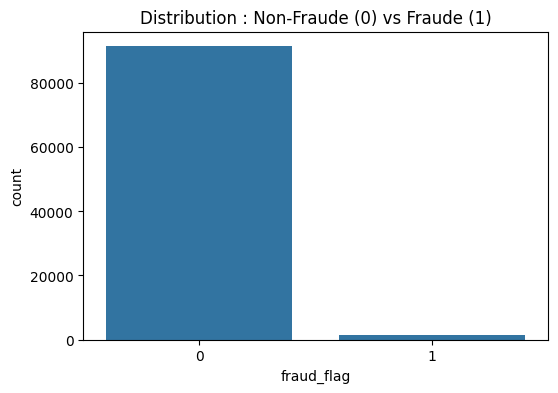

In [4]:
# Vérification du déséquilibre des classes
count_classes = df_train['fraud_flag'].value_counts()
share_classes = df_train['fraud_flag'].value_counts(normalize=True)

print("\nDistribution de la variable cible (fraud_flag) :")
print(count_classes)
print(f"\nPourcentage de fraude : {share_classes[1]:.2%}")

# Visualisation
plt.figure(figsize=(6, 4))
sns.countplot(x='fraud_flag', data=df_train)
plt.title('Distribution : Non-Fraude (0) vs Fraude (1)')
plt.show()

**Transformation du dataset**

On fait une première transformation pour pouvoir analyser les données.

In [5]:
# ==========================================
# 1. DÉFINITION DES FONCTIONS
# ==========================================

def transformer_en_format_long(df):
    """Transforme le format 'large' (147 colonnes) en 'long' (1 ligne par article)."""
    frames = []
    for i in range(1, 25):
        # Sélection des colonnes pour le slot i
        cols = ['ID', f'item{i}', f'make{i}', f'model{i}', f'cash_price{i}', f'Nbr_of_prod_purchas{i}']
        temp_df = df[cols].copy()
        temp_df.columns = ['ID', 'category', 'make', 'model', 'price', 'quantity']
        frames.append(temp_df)
    
    # Fusion et nettoyage des items vides
    df_long = pd.concat(frames, ignore_index=True)
    df_long = df_long.dropna(subset=['category'])
    return df_long

def concatenate_text(x):
    """Joint les textes d'un groupe en ignorant les vides."""
    return ' '.join([val for val in x.values if val != ''])

def creer_colonnes_binaires(df, col_text, prefixe, min_frequence):
    """Crée des dummies (0/1) à partir d'une colonne de texte concaténé."""
    vectorizer = CountVectorizer(binary=True, min_df=min_frequence)
    text_data = df[col_text].fillna('')
    X = vectorizer.fit_transform(text_data)
    cols = [f"{prefixe}_{word}" for word in vectorizer.get_feature_names_out()]
    return pd.DataFrame(X.toarray(), columns=cols, index=df.index)

# ==========================================
# 2. EXÉCUTION DU PIPELINE
# ==========================================
print("Démarrage du Feature Engineering...")

# A. Passage en format Long
df_items = transformer_en_format_long(df_train)

# B. Nettoyage basique du texte
for col in ['make', 'category', 'model']:
    df_items[col] = df_items[col].astype(str).str.lower().replace('nan', '')

print(f"Format Long : {df_items.shape}")
display(df_items.sample(5))

# C. Agrégations Numériques (Somme, Max, Moyenne...)
aggs_num = {'price': ['sum', 'max', 'min', 'mean', 'std'], 'quantity': ['sum']}
df_feats_num = df_items.groupby('ID').agg(aggs_num)
df_feats_num.columns = ['_'.join(col).strip() for col in df_feats_num.columns.values]

# D. Agrégations Textuelles (Concaténation pour Vectorizer)
df_feats_text = df_items.groupby('ID').agg({
    'category': concatenate_text,
    'make': concatenate_text,
    'model': concatenate_text
}).rename(columns={'category': 'list_cat', 'make': 'list_make', 'model': 'list_mod'})

# E. Création des variables binaires (One-Hot Encoding intelligent)
# Seuils ajustables : min_frequence=30 signifie "la marque doit apparaitre 30 fois min."
df_bin_cat  = creer_colonnes_binaires(df_feats_text, 'list_cat',  'cat',  min_frequence=5)
df_bin_make = creer_colonnes_binaires(df_feats_text, 'list_make', 'make', min_frequence=30)
df_bin_mod  = creer_colonnes_binaires(df_feats_text, 'list_mod',  'mod',  min_frequence=100) 

# ==========================================
# 3. FUSION FINALE
# ==========================================
df_final = df_feats_num.join([df_bin_cat, df_bin_make, df_bin_mod], how='left')

# Ajout de la variable cible (Y) depuis le fichier original
df_final = pd.merge(df_final, df_train[['ID', 'fraud_flag']], on='ID', how='inner')

# Remplissage des valeurs manquantes (ex: std sur 1 seul item)
df_final = df_final.fillna(0)

print("-" * 30)
print(f"Dataset prêt : {df_final.shape}")
display(df_final.head())

Démarrage du Feature Engineering...
Format Long : (163357, 6)


,ID,category,make,model,price,quantity
84630,20015,computer peripherals accessories,apple,apple watch series 6 gps cellular 40mm blue al...,479.0,1.0
286076,48532,storage organisation,retailer,retailer soft edge clothes rail oak,299.0,1.0
52601,45275,computers,apple,2020 apple macbook air 13 3 retina display m1 ...,893.0,1.0
83207,51348,computer peripherals accessories,apple,apple watch series 6 gps 44mm gold aluminium case,379.0,1.0
147167,14372,fulfilment charge,retailer,retailer,7.0,1.0


------------------------------
Dataset prêt : (92790, 733)


,ID,price_sum,price_max,price_min,price_mean,price_std,quantity_sum,cat_32gb,cat_850v6,cat_accessories,...,mod_xr,mod_xr50x90j,mod_xr55a80j,mod_xr55a90j,mod_xr55x90j,mod_xr65a80j,mod_xr65a90j,mod_xr65x90j,mod_xr77a80j,fraud_flag
0,0,1295.0,1249.0,11.0,431.666667,707.933142,3.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1048.0,679.0,369.0,524.000000,219.203102,2.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2,1989.0,1879.0,110.0,994.500000,1250.871896,2.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,999.0,999.0,0.0,499.500000,706.399674,2.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,749.0,749.0,749.0,749.000000,0.000000,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Statistiques descriptives des fraudeurs**

--- STATISTIQUES FINANCIÈRES : FRAUDE vs NON-FRAUDE ---
Métrique             | Fraude (Rouge)  | Non-Fraude (Bleu)
------------------------------------------------------------
Moyenne Panier       | 1547.47 €        | 1230.25 €
Médiane Panier       | 1379.00 €        | 1099.00 €
Min Panier           | 305.00 €        | 219.00 €
Max Panier           | 9018.00 €        | 21995.00 €


C:\Users\legachet\AppData\Local\Temp\ipykernel_4080\3668490836.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fraud_flag', y='price_sum', data=df_final, palette=['blue', 'red'])


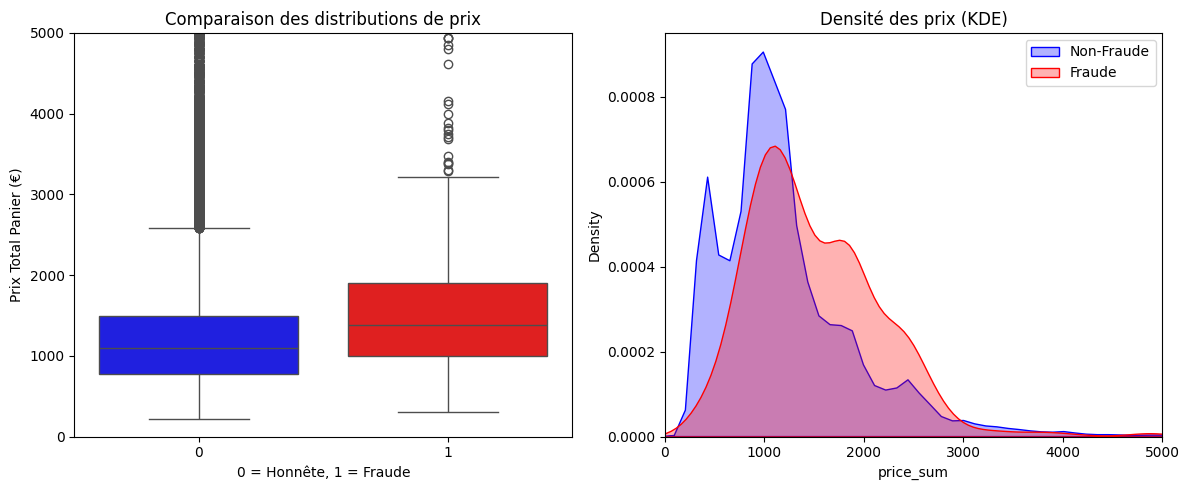


--- COMPARAISON DES MARQUES (MAKE) ---


C:\Users\legachet\AppData\Local\Temp\ipykernel_4080\3668490836.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_fraud.values, y=top_fraud.index, ax=axes[1], palette='Reds_r')
C:\Users\legachet\AppData\Local\Temp\ipykernel_4080\3668490836.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_legit.values, y=top_legit.index, ax=axes[0], palette='Blues_r')


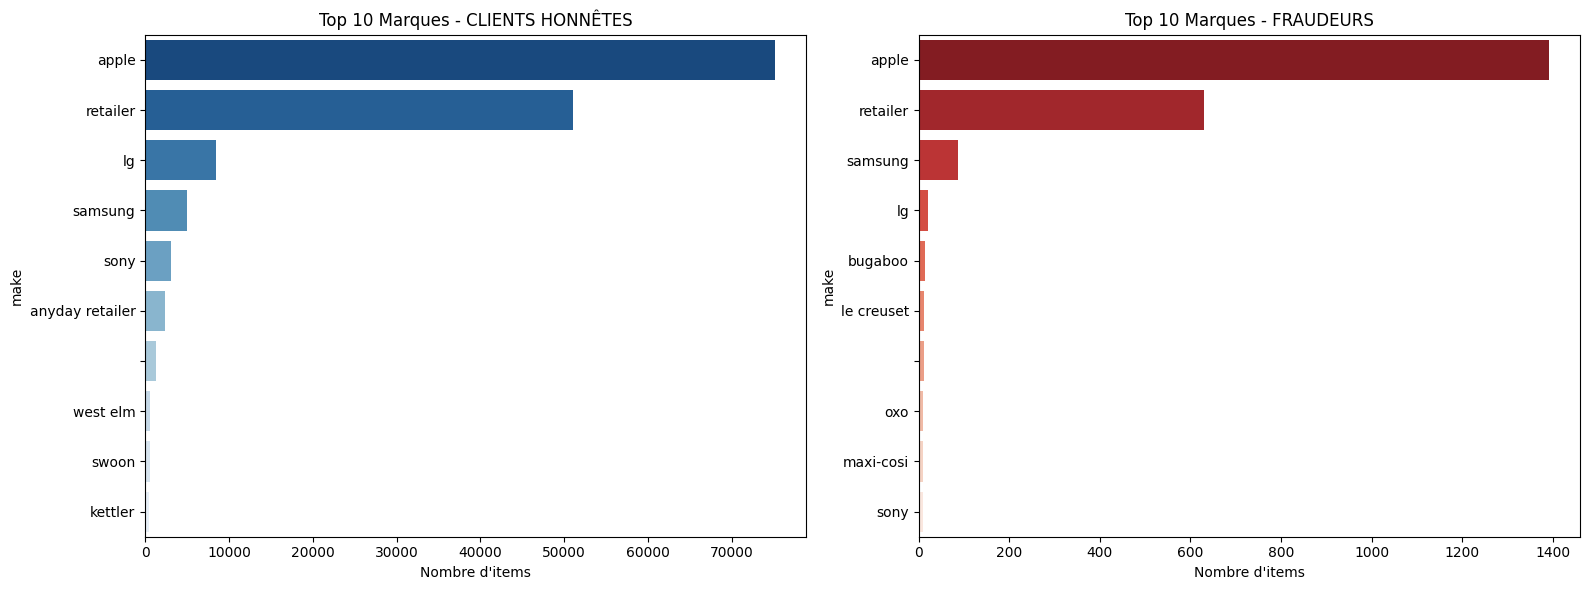


--- COMPARAISON DES CATÉGORIES ---


C:\Users\legachet\AppData\Local\Temp\ipykernel_4080\3668490836.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_fraud.values, y=top_fraud.index, ax=axes[1], palette='Reds_r')
C:\Users\legachet\AppData\Local\Temp\ipykernel_4080\3668490836.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_legit.values, y=top_legit.index, ax=axes[0], palette='Blues_r')


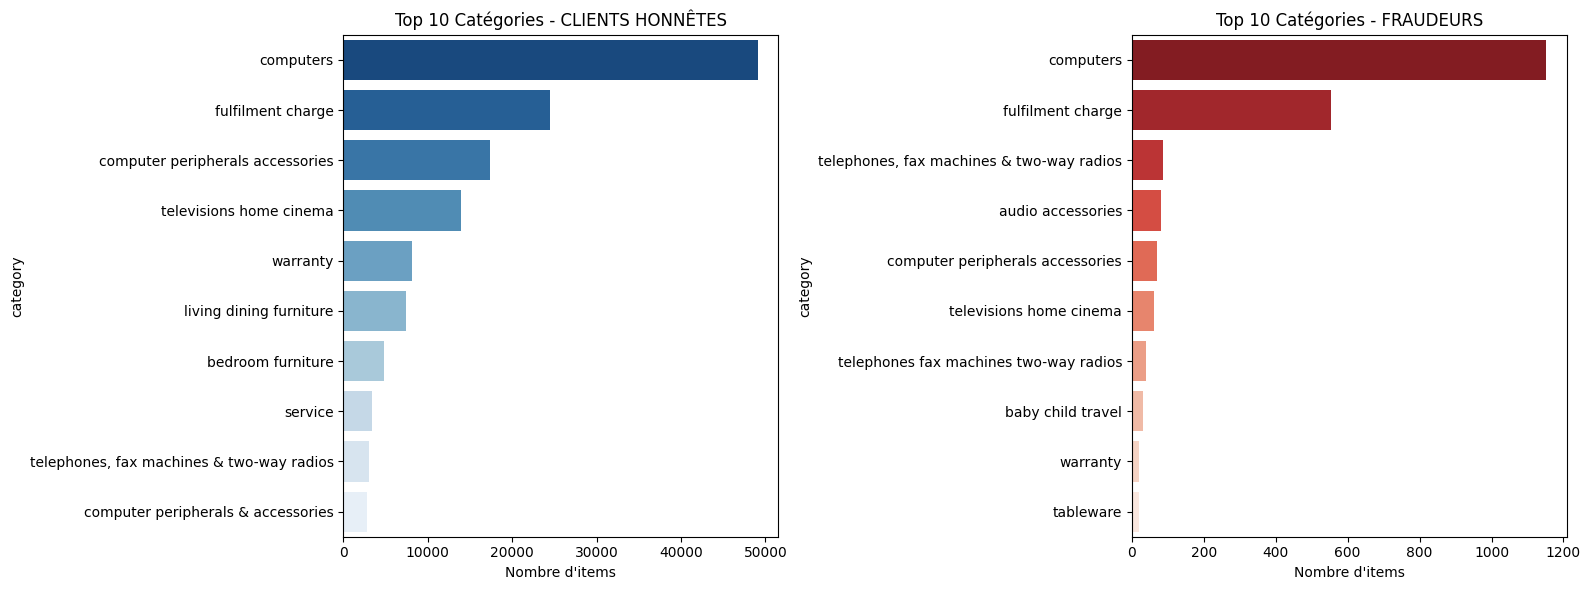


--- COMPARAISON DES MODÈLES (Top 10) ---
FRAUDEURS :
model
retailer                                              699
2020 apple macbook pro 13 touch bar m1 processor 8    172
2020 apple macbook air 13 3 retina display m1 proc    156
2021 apple macbook pro 14 m1 pro processor 16gb ra    155
2021 apple macbook pro 16 m1 pro processor 16gb ra     76
2021 apple ipad pro 11 m1 processor ios wi-fi 128g     73
2021 apple ipad pro 12 9 m1 processor ios wi-fi ce     64
2020 apple macbook pro 13 touch bar intel core i5      55
2021 apple ipad pro 12 9 m1 processor ios wi-fi 25     41
2021 apple ipad pro 12 9 m1 processor ios wi-fi 12     39
Name: count, dtype: int64

NON-FRAUDEURS :
model
retailer                                              42215
2020 apple macbook air 13 3 retina display m1 proc    12985
2020 apple macbook pro 13 touch bar m1 processor 8     5160
2021 apple macbook pro 14 m1 pro processor 16gb ra     3427
apple pencil 2nd generation 2018 matte white           2871
2020 apple 

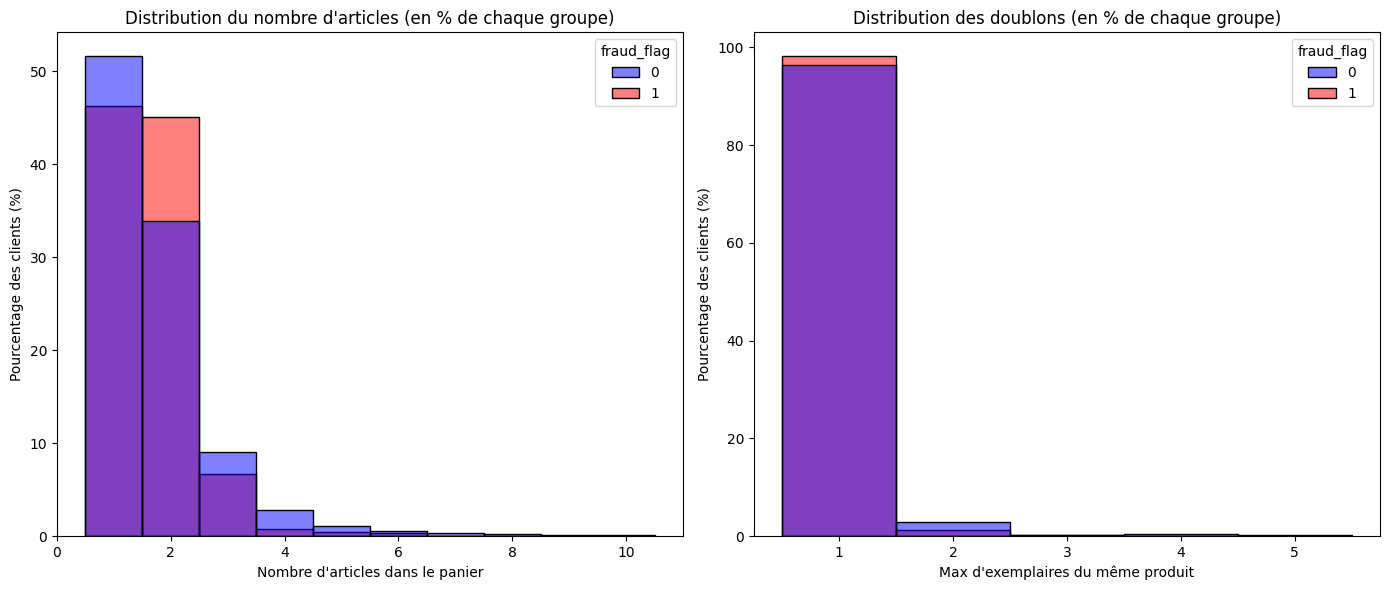

In [6]:
# 1. Préparation des datasets séparés
# On sépare les IDs
fraud_ids = df_train[df_train['fraud_flag'] == 1]['ID']
legit_ids = df_train[df_train['fraud_flag'] == 0]['ID']

# On sépare les Dataframes 'Items' (pour le détail produits)
items_fraud = df_items[df_items['ID'].isin(fraud_ids)]
items_legit = df_items[df_items['ID'].isin(legit_ids)]

# On sépare les Dataframes 'Final' (pour les montants globaux)
baskets_fraud = df_final[df_final['fraud_flag'] == 1]
baskets_legit = df_final[df_final['fraud_flag'] == 0]

# ==========================================
# PARTIE 1 : L'ARGENT (Comparaison des montants)
# ==========================================
print("--- STATISTIQUES FINANCIÈRES : FRAUDE vs NON-FRAUDE ---")
print(f"{'Métrique':<20} | {'Fraude (Rouge)':<15} | {'Non-Fraude (Bleu)':<15}")
print("-" * 60)
print(f"{'Moyenne Panier':<20} | {baskets_fraud['price_sum'].mean():.2f} €        | {baskets_legit['price_sum'].mean():.2f} €")
print(f"{'Médiane Panier':<20} | {baskets_fraud['price_sum'].median():.2f} €        | {baskets_legit['price_sum'].median():.2f} €")
print(f"{'Min Panier':<20} | {baskets_fraud['price_sum'].min():.2f} €        | {baskets_legit['price_sum'].min():.2f} €")
print(f"{'Max Panier':<20} | {baskets_fraud['price_sum'].max():.2f} €        | {baskets_legit['price_sum'].max():.2f} €")

# Graphique : Boxplot comparatif (Le meilleur pour voir les écarts de distribution)
plt.figure(figsize=(12, 5))

# Plot 1 : Boxplot (pour voir médianes et écarts)
plt.subplot(1, 2, 1)
sns.boxplot(x='fraud_flag', y='price_sum', data=df_final, palette=['blue', 'red'])
plt.title('Comparaison des distributions de prix')
plt.xlabel('0 = Honnête, 1 = Fraude')
plt.ylabel('Prix Total Panier (€)')
plt.ylim(0, 5000) # On zoome un peu pour voir mieux (ignorer les très gros outliers)

# Plot 2 : Histogrammes superposés (Normalisés pour comparer les formes)
plt.subplot(1, 2, 2)
sns.kdeplot(baskets_legit['price_sum'], color='blue', label='Non-Fraude', fill=True, alpha=0.3)
sns.kdeplot(baskets_fraud['price_sum'], color='red', label='Fraude', fill=True, alpha=0.3)
plt.title('Densité des prix (KDE)')
plt.xlim(0, 5000)
plt.legend()

plt.tight_layout()
plt.show()

# ==========================================
# PARTIE 2 : LE CONTENU (Comparaison des Marques)
# ==========================================
# Fonction pour afficher les tops côte à côte
def plot_top_comparison(df_fraud, df_legit, column, title):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Fraudeurs
    top_fraud = df_fraud[column].value_counts().head(10)
    sns.barplot(x=top_fraud.values, y=top_fraud.index, ax=axes[1], palette='Reds_r')
    axes[1].set_title(f'Top 10 {title} - FRAUDEURS')
    axes[1].set_xlabel('Nombre d\'items')
    
    # Non Fraudeurs
    top_legit = df_legit[column].value_counts().head(10)
    sns.barplot(x=top_legit.values, y=top_legit.index, ax=axes[0], palette='Blues_r')
    axes[0].set_title(f'Top 10 {title} - CLIENTS HONNÊTES')
    axes[0].set_xlabel('Nombre d\'items')
    
    plt.tight_layout()
    plt.show()

print("\n--- COMPARAISON DES MARQUES (MAKE) ---")
plot_top_comparison(items_fraud, items_legit, 'make', 'Marques')

print("\n--- COMPARAISON DES CATÉGORIES ---")
plot_top_comparison(items_fraud, items_legit, 'category', 'Catégories')

# ==========================================
# PARTIE 3 : LES MODÈLES (Comparaison texte)
# ==========================================
print("\n--- COMPARAISON DES MODÈLES (Top 10) ---")
print("FRAUDEURS :")
print(items_fraud['model'].value_counts().head(10))
print("\nNON-FRAUDEURS :")
print(items_legit['model'].value_counts().head(10))


# =========================
# PARTIE 4 : LES QUANTITÉS 
# =========================
print("\n--- ANALYSE DES QUANTITÉS ---")

# 1. Calcul des métriques de quantité par panier (depuis df_items)
# On regroupe par ID pour avoir :
# - Somme : Nombre total d'articles dans le panier
# - Max : La plus grande quantité d'un même article (ex: a-t-il pris 5 fois le même objet ?)
qty_stats = df_items.groupby('ID')['quantity'].agg(['sum', 'max']).reset_index()
qty_stats.columns = ['ID', 'total_items', 'max_qty_same_item']

# On rajoute le flag fraude
qty_stats = pd.merge(qty_stats, df_train[['ID', 'fraud_flag']], on='ID', how='inner')

# On filtre pour garder une vue lisible (moins de 10 articles)
subset_stats = qty_stats[qty_stats['total_items'] <= 10]

plt.figure(figsize=(14, 6))

# --- GRAPHIQUE 1 : Nombre total d'articles (Normalisé en %) ---
plt.subplot(1, 2, 1)
sns.histplot(
    data=subset_stats,
    x='total_items',
    hue='fraud_flag',
    stat='percent',      # <--- C'est la clé : on affiche des %
    common_norm=False,   # <--- Important : calcule le 100% séparément pour Rouge et Bleu
    discrete=True,       # Pour avoir des barres bien centrées sur 1, 2, 3...
    palette=['blue', 'red'],
    alpha=0.5            # Transparence pour voir les superpositions
)
plt.title('Distribution du nombre d\'articles (en % de chaque groupe)')
plt.ylabel('Pourcentage des clients (%)')
plt.xlabel("Nombre d'articles dans le panier")

# --- GRAPHIQUE 2 : Quantité du MÊME article (Normalisé en %) ---
plt.subplot(1, 2, 2)
# On filtre ceux qui ont pris moins de 5 fois le même objet
subset_doublons = qty_stats[qty_stats['max_qty_same_item'] <= 5]

sns.histplot(
    data=subset_doublons,
    x='max_qty_same_item',
    hue='fraud_flag',
    stat='percent',
    common_norm=False,
    discrete=True,
    palette=['blue', 'red'],
    alpha=0.5
)
plt.title('Distribution des doublons (en % de chaque groupe)')
plt.ylabel('Pourcentage des clients (%)')
plt.xlabel("Max d'exemplaires du même produit")

plt.tight_layout()
plt.show()

Le prix est important : 
- Le prix des paniers des fraudeurs est moyenne supérieur.
- On remarque au niveau de la densité qu'entre 1 500 et 3000 euros de panier, la probabilité d'être fraudeur semble plus détectable comparé à un non-fraudeur. Le Boxplot rouge montre que c'est très "tassé" entre 1000€ et 2000€. 
- Les fraudeurs évitent les petits montants (pas rentable).

Les fraudeurs ont l'air de moins se concentrer sur les accessoires, les garanties ou les "services". Les fraudeurs achètent directement le MacBook Pro 14 M1 par exemple, et ne voit pas l'intérêt de prendre l'assurance vol/casse ou rarement le petit câble à 10€. Il va droit au but.

Au niveau des marques, les non-fraudeurs sont plus diversifiés alors que les fraudeurs se concentrent sur les marques facilement revendables comme Apple et un petit peu Samsung.

On ne semble pas tiré grand chose au niveau des quantités.

**Rajout de colonnes en fonction des caractéristiques des fraudeurs**

Suite à ce que nous avons vu avant, il serait pertient de rajouter 4 colonnes :

- make_apple_samsung : vaut 1 si le panier contient samsung ou apple, 0 sinon.
- price_1500_3000 : 1 si le produit est entre 1500 et 3000 euros, 0 sinon.
- price_under_600 : 1 si le produit vaut moins de 600, 0 sinon.
- category_service : 1 si il y a warranty ou service, 0 sinon.

In [7]:
# 1. On récupère les textes depuis df_items (le fichier vertical)

def join_text(x):
    return ' '.join([str(v) for v in x if str(v) != 'nan' and str(v) != ''])

# On recrée un petit tableau temporaire avec juste les textes par ID
temp_text = df_items.groupby('ID').agg({
    'make': join_text,
    'category': join_text
}).rename(columns={'make': 'list_make', 'category': 'list_cat'})

# 2. On calcule les flags Textuels sur ce tableau temporaire

# Flag Apple/Samsung
temp_text['make_apple_samsung'] = temp_text['list_make'].str.contains('apple|samsung', case=False, regex=True).astype(int)

# Flag Service/Garantie
temp_text['category_service'] = temp_text['list_cat'].str.contains('warranty|service', case=False, regex=True).astype(int)

# 3. On injecte ces nouvelles colonnes dans df_final
cols_to_add = ['make_apple_samsung', 'category_service']

# Petit nettoyage
df_final = df_final.drop(columns=[c for c in cols_to_add if c in df_final.columns], errors='ignore')

df_final = pd.merge(df_final, temp_text[cols_to_add], on='ID', how='left')

# Remplir les NaN par 0 (au cas où un ID n'avait pas de make)
df_final[cols_to_add] = df_final[cols_to_add].fillna(0).astype(int)

# 4. On ajoute les flags de PRIX 
df_final['price_1500_3000'] = ((df_final['price_sum'] >= 1500) & (df_final['price_sum'] <= 3000)).astype(int)
df_final['price_under_600'] = (df_final['price_sum'] < 600).astype(int)

# 5. Vérification
print("-" * 30)
print("Flags ajoutés")
cols_check = ['fraud_flag', 'make_apple_samsung', 'category_service', 'price_1500_3000', 'price_under_600']
display(df_final[cols_check].head())

------------------------------
Flags ajoutés


,fraud_flag,make_apple_samsung,category_service,price_1500_3000,price_under_600
0,0,1,1,0,0
1,0,0,0,0,0
2,0,0,0,1,0
3,0,1,0,0,0
4,0,0,0,0,0


**Statistiques descriptives des intéractions**

In [8]:
# 1. Nettoyage et Préparation
# On exclut le 'fulfilment charge' et on s'assure que tout est en minuscule
df_clean = df_items[
    (df_items['category'].str.lower() != 'fulfilment charge') & 
    (df_items['model'].str.lower() != 'retailer') &
    (df_items['model'].notna())
].copy()

# On nettoie les textes
df_clean['model'] = df_clean['model'].astype(str).str.lower().str.strip()
df_clean['category'] = df_clean['category'].astype(str).str.lower().str.strip()

# 2. Fonction pour trouver les paires fréquentes
def get_top_pairs(df_source, target_ids, column_name='model', top_n=10):
    # On ne garde que les items des IDs concernés
    subset = df_source[df_source['ID'].isin(target_ids)]
    
    # On regroupe les items par Panier (ID)
    baskets = subset.groupby('ID')[column_name].apply(list)
    
    pair_counts = Counter()
    
    for basket in baskets:
        # On trie le panier pour que (A, B) soit pareil que (B, A)
        basket.sort()
        # On ne regarde que les paniers avec au moins 2 articles
        if len(basket) >= 2:
            # On génère toutes les combinaisons de 2 articles
            pair_counts.update(combinations(basket, 2))
            
    return pair_counts.most_common(top_n)

# 3. Application : Fraudeurs vs Non-Fraudeurs
fraud_ids = df_train[df_train['fraud_flag'] == 1]['ID']
legit_ids = df_train[df_train['fraud_flag'] == 0]['ID']

print("--- TOP 10 DES PAIRES DE MODÈLES (PRODUITS EXACTS) ---")

print("\n--- CHEZ LES FRAUDEURS (Quels duos volent-ils ?) ---")
pairs_fraud = get_top_pairs(df_clean, fraud_ids, column_name='model', top_n=10)
for pair, count in pairs_fraud:
    print(f"{count} fois : {pair[0]}  +  {pair[1]}")

print("\n--- CHEZ LES HONNÊTES (Quels duos achètent-ils ?) ---")
pairs_legit = get_top_pairs(df_clean, legit_ids, column_name='model', top_n=10)
for pair, count in pairs_legit:
    print(f"{count} fois : {pair[0]}  +  {pair[1]}")









print("\n" + "="*60 + "\n")
print("--- TOP 10 DES PAIRES DE CATÉGORIES ---")

print("\n--- CHEZ LES FRAUDEURS ---")
cat_pairs_fraud = get_top_pairs(df_clean, fraud_ids, column_name='category', top_n=10)
for pair, count in cat_pairs_fraud:
    print(f"{count} fois : {pair[0]}  +  {pair[1]}")

print("\n--- CHEZ LES HONNÊTES ---")
cat_pairs_legit = get_top_pairs(df_clean, legit_ids, column_name='category', top_n=10)
for pair, count in cat_pairs_legit:
    print(f"{count} fois : {pair[0]}  +  {pair[1]}")

--- TOP 10 DES PAIRES DE MODÈLES (PRODUITS EXACTS) ---

--- CHEZ LES FRAUDEURS (Quels duos volent-ils ?) ---
12 fois : 2020 apple macbook pro 13 touch bar m1 processor 8  +  2021 apple ipad pro 11 m1 processor ios wi-fi 128g
10 fois : 2020 apple macbook air 13 3 retina display m1 proc  +  2021 apple ipad pro 11 m1 processor ios wi-fi 128g
10 fois : 2020 apple macbook pro 13 touch bar m1 processor 8  +  apple airpods max noise cancelling wireless blueto
7 fois : 2020 apple macbook pro 13 touch bar m1 processor 8  +  apple airpods pro with wireless charging case
7 fois : 2021 apple ipad pro 12 9 m1 processor ios wi-fi ce  +  apple airpods max noise cancelling wireless blueto
6 fois : 2020 apple macbook air 13 3 retina display m1 proc  +  2021 apple ipad pro 12 9 m1 processor ios wi-fi 25
5 fois : 2020 apple macbook pro 13 touch bar intel core i5  +  apple airpods pro with wireless charging case
5 fois : 2020 apple macbook pro 13 touch bar m1 processor 8  +  2021 apple ipad pro 12 9 m1 pr

Les fraudeurs prennent le MacBook + l'iPad Pro, ou le MacBook + le Casque AirPods Max (le plus cher). Ce sont deux produits autonomes à très forte valeur ajoutée. Ils maximisent le "butin".

Les gens honnêtes prennent l'iPad + le Pencil (Stylet), ou le MacBook + l'Adaptateur USB. C'est une logique d'utilisation (j'ai besoin du stylet pour dessiner sur ma tablette). Un fraudeur ne s'embête pas à voler un adaptateur USB à 20€ ou un stylet difficile à revendre seul.

La paire computers + computers arrive 2ème chez les fraudeurs.

Chez les gens honnêtes, c'est computer + peripherals (Ordi + Souris).

Ainsi, acheter 2 ordinateurs d'un coup est un signal d'alarme.

In [9]:
# On prépare des listes de mots-clés basées sur nos découvertes
keywords_computers = ['computer', 'macbook', 'laptop', 'imac']
keywords_tablets = ['ipad', 'tablet']
keywords_accessories = ['pencil', 'adaptor', 'adapter', 'cable', 'mouse', 'keyboard', 'cover', 'case']
keywords_baby_travel = ['baby child travel', 'bugaboo', 'pushchair', 'stroller']

def count_keywords(text_series, keywords):
    # Compte combien de fois un des mots-clés apparait dans le panier
    return text_series.apply(lambda x: sum(1 for k in keywords if k in str(x).lower())).sum()

# On crée un tableau temporaire par ID
df_interact = df_items.groupby('ID').apply(lambda x: pd.Series({
    # 1. Combien d'ordinateurs dans le panier ? (Pour détecter Computer + Computer)
    'nb_computers': count_keywords(x['category'], ['computers']) + count_keywords(x['model'], keywords_computers),
    
    # 2. Combien de tablettes ?
    'nb_tablets': count_keywords(x['model'], keywords_tablets),
    
    # 3. Combien d'accessoires "honnêtes" (Pencil, Adapter...) ?
    'nb_honest_accessories': count_keywords(x['model'], keywords_accessories)
    
})).reset_index()

# --- CRÉATION DES FLAGS D'INTERACTION ---

# A. Flag "Gourmandise High-Tech" : Avoir au moins 2 gros appareils (Ordi+Ordi ou Ordi+Tablette)
df_interact['flag_multi_hightech'] = ((df_interact['nb_computers'] + df_interact['nb_tablets']) >= 2).astype(int)

# B. Flag "Logique Honnête" : Avoir un appareil cher MAIS avec un accessoire pas cher
# (Si j'ai un ordi ET un accessoire, je suis probablement honnête)
df_interact['flag_logic_usage'] = ((df_interact['nb_computers'] > 0) & (df_interact['nb_honest_accessories'] > 0)).astype(int)


# --- FUSION AVEC DF_FINAL ---
print("Ajout des interactions au dataset final...")
cols_interact = ['nb_computers', 'flag_multi_hightech', 'flag_logic_usage']

# Nettoyage préventif
df_final = df_final.drop(columns=[c for c in cols_interact if c in df_final.columns], errors='ignore')

# Fusion
df_final = pd.merge(df_final, df_interact[['ID'] + cols_interact], on='ID', how='left')
df_final[cols_interact] = df_final[cols_interact].fillna(0)

cols_check = ['fraud_flag', 'nb_computers', 'flag_multi_hightech', 'flag_logic_usage']
display(df_final[cols_check].head())

C:\Users\legachet\AppData\Local\Temp\ipykernel_4080\3966824142.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_interact = df_items.groupby('ID').apply(lambda x: pd.Series({


Ajout des interactions au dataset final...


,fraud_flag,nb_computers,flag_multi_hightech,flag_logic_usage
0,0,2,1,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


**Modèles**

Entraînement sur 738 variables...
Lancement de l'entraînement XGBoost

SCORE PR-AUC OBTENU : 0.1951
Rappel Benchmark 2 (Objectif) : 0.1400


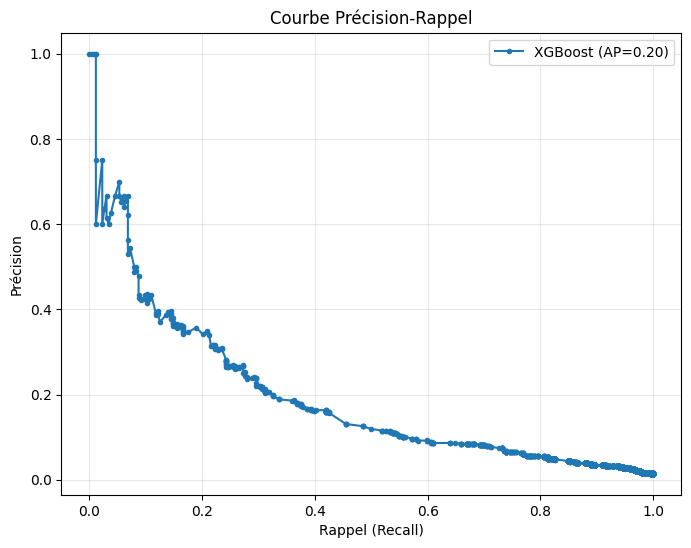

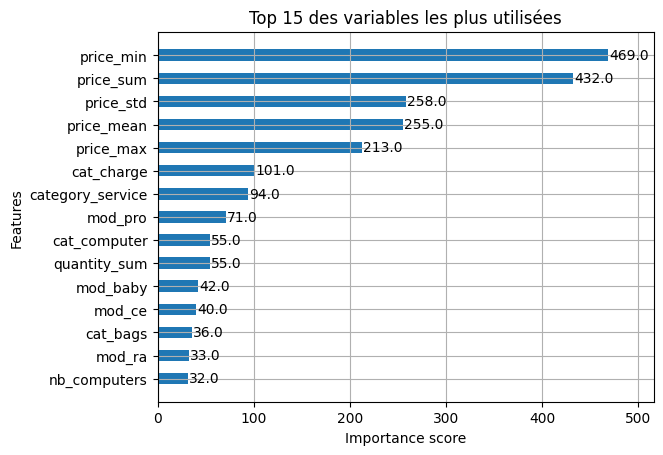

In [10]:
# 1. Préparation des données (X et Y)
# On enlève l'ID et la cible (fraud_flag) de X
features = [col for col in df_final.columns if col not in ['ID', 'fraud_flag']]
X = df_final[features]
y = df_final['fraud_flag']

print(f"Entraînement sur {X.shape[1]} variables...")

# 2. Split Train / Validation 
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Configuration du modèle XGBoost
ratio = float(np.sum(y == 0)) / np.sum(y == 1)

model = xgb.XGBClassifier(
    n_estimators=200,        # Nombre d'arbres
    learning_rate=0.05,      # Vitesse d'apprentissage
    max_depth=5,             # Profondeur des arbres (éviter le sur-apprentissage)
    scale_pos_weight=ratio,  # GESTION DU DÉSÉQUILIBRE
    random_state=42,
    n_jobs=-1                # Utilise tous les cœurs du CPU
)

# 4. Entraînement
print("Lancement de l'entraînement XGBoost")
model.fit(X_train, y_train)

# 5. Prédiction
y_pred_proba = model.predict_proba(X_val)[:, 1]

# 6. Calcul du Score (PR-AUC)
score_pr_auc = average_precision_score(y_val, y_pred_proba)

print("\n" + "="*40)
print(f"SCORE PR-AUC OBTENU : {score_pr_auc:.4f}")
print("="*40)
print(f"Rappel Benchmark 2 (Objectif) : 0.1400")

# 7. Courbe Précision-Rappel
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'XGBoost (AP={score_pr_auc:.2f})')
plt.xlabel('Rappel (Recall)')
plt.ylabel('Précision')
plt.title('Courbe Précision-Rappel')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 8. Quelles sont les variables gagnantes ? (Feature Importance)
xgb.plot_importance(model, max_num_features=15, importance_type='weight', height=0.5)
plt.title("Top 15 des variables les plus utilisées")
plt.show()

Le modèle confirme que le comportement financier est le premier indicateur. Les fraudeurs ont une signature financière très précise (ni trop bas, ni trop haut).

L'importance de category_service : c'est la 5ème variable la plus importante. Cela prouve que savoir ce que le client n'est pas (un client prudent qui prend une garantie) est aussi utile que de savoir ce qu'il est.

Les mots-clés "Pro" (mod_pro) : Le modèle a capté que "MacBook Pro", "iPad Pro", "iPhone Pro" sont des cibles privilégiées. C'est plus fin que juste "Apple".

nb_computers : La variable d'interaction est dans le top 15. Le fait de compter les ordis sert au modèle.

Au niveau de la courbe Précision-Rappel :

Elle chute assez vite au début. Cela signifie que le modèle est très sûr pour détecter les fraudes évidentes (les "gros" fraudeurs), mais dès qu'il s'agit de cas limites, il hésite.

Pour améliorer cela, il faudra plus tard travailler sur les "faux positifs" (les clients honnêtes qui ont l'air de fraudeurs).

**Créer le fichier de soumission**

In [11]:

# ==========================================
# 1. CONFIGURATION & FONCTIONS
# ==========================================

def transformer_en_format_long(df):
    """Transforme le format 'large' en 'long'."""
    frames = []
    for i in range(1, 25):
        # On inclut 'is_train' et 'fraud_flag' pour ne pas les perdre
        cols = ['ID', 'is_train', 'fraud_flag', f'item{i}', f'make{i}', f'model{i}', f'cash_price{i}', f'Nbr_of_prod_purchas{i}']
        temp_df = df[cols].copy()
        temp_df.columns = ['ID', 'is_train', 'fraud_flag', 'category', 'make', 'model', 'price', 'quantity']
        frames.append(temp_df)
    
    df_long = pd.concat(frames, ignore_index=True)
    df_long = df_long.dropna(subset=['category'])
    return df_long

def concatenate_text(x):
    """Joint les textes d'un groupe en ignorant les vides."""
    return ' '.join([val for val in x.values if val != ''])

def creer_colonnes_binaires(df, col_text, prefixe, min_frequence):
    """Crée des dummies (0/1) à partir d'une colonne de texte."""
    # On remplit les NaN avant vectorisation
    text_data = df[col_text].fillna('')
    vectorizer = CountVectorizer(binary=True, min_df=min_frequence)
    X = vectorizer.fit_transform(text_data)
    cols = [f"{prefixe}_{word}" for word in vectorizer.get_feature_names_out()]
    return pd.DataFrame(X.toarray(), columns=cols, index=df.index)

def count_keywords(text_series, keywords):
    """Compte les mots clés dans une série."""
    return text_series.apply(lambda x: sum(1 for k in keywords if k in str(x).lower())).sum()

# ==========================================
# 2. CHARGEMENT ET FUSION (TRAIN + TEST)
# ==========================================
print("Chargement des données...")
df_x_train = pd.read_csv('data/X_train_G3tdtEn.csv')
df_y_train = pd.read_csv('data/Y_train_2_XPXJDyy.csv')
df_x_test  = pd.read_csv('data/X_test_8skS2ey.csv')

# Fusion Train
df_train = pd.merge(df_x_train, df_y_train, on='ID', how='inner')

# Marquage pour s'y retrouver après
df_train['is_train'] = 1
df_x_test['is_train'] = 0
df_x_test['fraud_flag'] = np.nan 

# Concaténation Globale
df_all = pd.concat([df_train, df_x_test], ignore_index=True)
print(f"Dataset Global (Train + Test) : {df_all.shape}")

# ==========================================
# 3. FEATURE ENGINEERING (TA PIPELINE)
# ==========================================
print("Transformation des données")

# A. Passage en format Long
df_items = transformer_en_format_long(df_all)

# B. Nettoyage Texte
for col in ['make', 'category', 'model']:
    df_items[col] = df_items[col].astype(str).str.lower().replace('nan', '')

# C. Agrégations Numériques (Prix, Quantité)
print("Agrégations numériques...")
aggs_num = {'price': ['sum', 'max', 'min', 'mean', 'std'], 'quantity': ['sum']}
df_feats_num = df_items.groupby('ID').agg(aggs_num)
df_feats_num.columns = ['_'.join(col).strip() for col in df_feats_num.columns.values]

# D. Agrégations Textuelles
print("Agrégations textuelles...")
df_feats_text = df_items.groupby('ID').agg({
    'category': concatenate_text,
    'make': concatenate_text,
    'model': concatenate_text
}).rename(columns={'category': 'list_cat', 'make': 'list_make', 'model': 'list_mod'})

# E. Variables Binaires (CountVectorizer)
# Seuils ajustés légèrement pour le dataset global
df_bin_cat  = creer_colonnes_binaires(df_feats_text, 'list_cat',  'cat',  min_frequence=5)
df_bin_make = creer_colonnes_binaires(df_feats_text, 'list_make', 'make', min_frequence=30)
df_bin_mod  = creer_colonnes_binaires(df_feats_text, 'list_mod',  'mod',  min_frequence=100)

# F. Création des Flags Spécifiques (Apple, Service, Prix)
print("Calcul des flags experts")
# On réutilise df_feats_text qui contient déjà les listes concaténées
df_flags = pd.DataFrame(index=df_feats_text.index)

# Flag Apple/Samsung
df_flags['make_apple_samsung'] = df_feats_text['list_make'].str.contains('apple|samsung', case=False, regex=True).astype(int)
# Flag Service
df_flags['category_service'] = df_feats_text['list_cat'].str.contains('warranty|service', case=False, regex=True).astype(int)

# G. Création des Interactions (Computers, Logic Usage)
print("Calcul des interactions complexes...")
keywords_computers = ['computer', 'macbook', 'laptop', 'imac']
keywords_tablets = ['ipad', 'tablet']
keywords_accessories = ['pencil', 'adaptor', 'adapter', 'cable', 'mouse', 'keyboard', 'cover', 'case']
keywords_baby_travel = ['baby child travel', 'bugaboo', 'pushchair', 'stroller']

# On utilise df_items pour compter précisément item par item
df_interact = df_items.groupby('ID').apply(lambda x: pd.Series({
    'nb_computers': count_keywords(x['category'], ['computers']) + count_keywords(x['model'], keywords_computers),
    'nb_tablets': count_keywords(x['model'], keywords_tablets),
    'nb_honest_accessories': count_keywords(x['model'], keywords_accessories)
})).reset_index().set_index('ID')

df_interact['flag_multi_hightech'] = ((df_interact['nb_computers'] + df_interact['nb_tablets']) >= 2).astype(int)
df_interact['flag_logic_usage'] = ((df_interact['nb_computers'] > 0) & (df_interact['nb_honest_accessories'] > 0)).astype(int)

# ==========================================
# 4. FUSION FINALE ET NETTOYAGE
# ==========================================
print("Fusion finale")
# On part des stats numériques comme base
df_final = df_feats_num.join([df_bin_cat, df_bin_make, df_bin_mod, df_flags, df_interact], how='left')

# On ajoute les Flags de Prix (basés sur price_sum qui est dans df_feats_num)
df_final['price_1500_3000'] = ((df_final['price_sum'] >= 1500) & (df_final['price_sum'] <= 3000)).astype(int)
df_final['price_under_600'] = (df_final['price_sum'] < 600).astype(int)

# On recolle les infos vitales (is_train, fraud_flag) depuis le dataset global
# On utilise drop_duplicates car un ID apparait plusieurs fois dans df_items mais une seule fois ici
info_cols = df_all[['ID', 'is_train', 'fraud_flag']].drop_duplicates(subset=['ID']).set_index('ID')
df_final = df_final.join(info_cols, how='inner')

# Remplissage des NaN (ex: std sur 1 item)
df_final = df_final.fillna(0)

print(f"Dataset Final prêt : {df_final.shape}")

# ==========================================
# 5. ENTRAINEMENT ET PRÉDICTION
# ==========================================

# Séparation Train / Test
df_train_ready = df_final[df_final['is_train'] == 1]
df_test_ready  = df_final[df_final['is_train'] == 0]

X = df_train_ready.drop(columns=['is_train', 'fraud_flag'])
y = df_train_ready['fraud_flag']

# Le Test set pour la prédiction
X_test_submit = df_test_ready.drop(columns=['is_train', 'fraud_flag'])

print(f"Entraînement sur {X.shape[0]} lignes et {X.shape[1]} colonnes...")

# Configuration XGBoost (Tes paramètres)
ratio = float(np.sum(y == 0)) / np.sum(y == 1)
model = xgb.XGBClassifier(
    n_estimators=300,       
    learning_rate=0.05,
    max_depth=5,
    scale_pos_weight=ratio,
    random_state=42,
    n_jobs=-1
)

model.fit(X, y)

# Prédiction
print("Génération des prédictions...")
probs = model.predict_proba(X_test_submit)[:, 1]

# ==========================================
# 6. CRÉATION SÉCURISÉE DU FICHIER DE SOUMISSION
# ==========================================
print("Génération sécurisée du fichier de soumission...")

# 1. On crée un Dictionnaire : { ID_CLIENT : PROBABILITÉ }
dict_preds = dict(zip(df_test_ready.index, probs))

# 2. On charge le fichier X_test ORIGINAL pour récupérer l'ordre EXACT attendu
df_submission_template = pd.read_csv('data/X_test_8skS2ey.csv', usecols=['ID'])

# 3. On injecte tes prédictions en utilisant l'ID comme clé de correspondance
df_submission_template['fraud_flag'] = df_submission_template['ID'].map(dict_preds)

# Sécurité : Si un ID n'a pas été trouvé (ne devrait pas arriver), on met 0
df_submission_template['fraud_flag'] = df_submission_template['fraud_flag'].fillna(0)

# 4. Formatage de l'index
df_submission_template.index.name = 'index'

# 5. Sauvegarde
filename = 'submission_1.csv'
df_submission_template.to_csv(filename, index=True)

print(f"Fichier '{filename}' généré")

Chargement des données...


C:\Users\legachet\AppData\Local\Temp\ipykernel_4080\643118161.py:40: DtypeWarning: Columns (21,22,23,24,69,70,71,72,93,94,95,96,97,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120) have mixed types. Specify dtype option on import or set low_memory=False.
  df_x_train = pd.read_csv('data/X_train_G3tdtEn.csv')
C:\Users\legachet\AppData\Local\Temp\ipykernel_4080\643118161.py:42: DtypeWarning: Columns (20,21,22,23,24,68,69,70,71,72,92,93,94,95,96,97,106,107,108,109,110,111,112,113,114,115,116,117,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df_x_test  = pd.read_csv('data/X_test_8skS2ey.csv')


Dataset Global (Train + Test) : (115988, 149)
Transformation des données
Agrégations numériques...
Agrégations textuelles...
Calcul des flags experts
Calcul des interactions complexes...


C:\Users\legachet\AppData\Local\Temp\ipykernel_4080\643118161.py:106: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_interact = df_items.groupby('ID').apply(lambda x: pd.Series({


Fusion finale
Dataset Final prêt : (115988, 844)
Entraînement sur 92790 lignes et 842 colonnes...
Génération des prédictions...
Génération sécurisée du fichier de soumission...
Fichier 'submission_1.csv' généré


**Résultats de la première soumission**

Cette première proposition me donne un résultat de 0,171. Le modèle de référence est donc battu de +22 %.

**Amélioration du modèle**

Nous allons optimiser les hyperparamètres.

In [12]:
print("Optimisation des hyperparamètres en cours.")

# 1. On définit la grille des paramètres à tester
param_dist = {
    'n_estimators': [200, 300, 500, 700],        # Nombre d'arbres
    'learning_rate': [0.01, 0.03, 0.05, 0.1],    # Vitesse (plus lent = souvent meilleur)
    'max_depth': [3, 4, 5, 6, 8],                # Complexité de l'arbre (trop haut = overfitting)
    'min_child_weight': [1, 3, 5],               # Poids min pour créer une feuille (évite le bruit)
    'gamma': [0, 0.1, 0.2],                      # Réduction de perte min
    'subsample': [0.7, 0.8, 0.9, 1.0],           # % de lignes utilisées par arbre
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],    # % de colonnes utilisées par arbre
    'scale_pos_weight': [ratio, ratio * 1.5]     # On teste de punir encore plus les erreurs sur la fraude
}

# 2. Configuration de la validation croisée
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 3. Initialisation du modèle de base
xgb_base = xgb.XGBClassifier(random_state=42, n_jobs=-1)

# 4. Lancement de la recherche (Random Search)
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=20,
    scoring='average_precision',
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42
)

# On entraine sur X et y
random_search.fit(X, y)

# 5. Résultats
print(f"\nMeilleur score PR-AUC trouvé sur le Train : {random_search.best_score_:.4f}")
print("Meilleurs paramètres :")
print(random_search.best_params_)

# 6. On utilise le meilleur modèle pour la prédiction finale
best_model = random_search.best_estimator_

print("Génération des prédictions avec le modèle optimisé.")
probs = best_model.predict_proba(X_test_submit)[:, 1]

Optimisation des hyperparamètres en cours.
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Meilleur score PR-AUC trouvé sur le Train : 0.1913
Meilleurs paramètres :
{'subsample': 1.0, 'scale_pos_weight': np.float64(69.34874905231236), 'n_estimators': 700, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.6}
Génération des prédictions avec le modèle optimisé.


**Test du modèle avec hyperparamètres optimisé**

In [13]:
# ==========================================
# 6. CRÉATION SÉCURISÉE DU FICHIER DE SOUMISSION
# ==========================================
print("Génération sécurisée du fichier de soumission.")

# 1. On crée un Dictionnaire : { ID_CLIENT : PROBABILITÉ }
dict_preds = dict(zip(df_test_ready.index, probs))

# 2. On charge le fichier X_test ORIGINAL pour récupérer l'ordre EXACT attendu
df_submission_template = pd.read_csv('data/X_test_8skS2ey.csv', usecols=['ID'])

# 3. On injecte tes prédictions en utilisant l'ID comme clé de correspondance
df_submission_template['fraud_flag'] = df_submission_template['ID'].map(dict_preds)

# Sécurité : Si un ID n'a pas été trouvé (ne devrait pas arriver), on met 0
df_submission_template['fraud_flag'] = df_submission_template['fraud_flag'].fillna(0)

# 4. Formatage de l'index
df_submission_template.index.name = 'index'

# 5. Sauvegarde
filename = 'submission_2.csv'
df_submission_template.to_csv(filename, index=True)

print(f"Fichier '{filename}' généré")

Génération sécurisée du fichier de soumission.
Fichier 'submission_2.csv' généré


**Résultat avec hyperparamètre optimisé**

Nous sommes passé de 0,171 à 0,176 en réglant les hyperparamètres.

**Méthode XGBoost + Random Forest**

Si on entraîne un modèle d'une famille totalement différente (comme un Random Forest), il fera des erreurs différentes. En faisant la moyenne des deux ((Pred_XGB + Pred_RF) / 2), les erreurs s'annulent souvent et le score monte.

In [14]:
# 1. On entraîne un Random Forest
print("Entraînement du Random Forest.")
rf_model = RandomForestClassifier(
    n_estimators=300,        # Nombre d'arbres
    max_depth=15,            # Plus profond que XGBoost car pas de boosting
    min_samples_leaf=5,      # Pour éviter le par-cœur
    class_weight='balanced', # Gestion du déséquilibre
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rf_model.fit(X, y)

# 2. On récupère les probabilités du RF
print("Prédiction avec Random Forest.")
probs_rf = rf_model.predict_proba(X_test_submit)[:, 1]

# 3. On fait la moyenne avec ton XGBoost optimisé 
# Formule : 0.7 * XGBoost + 0.3 * Random Forest
print("Calcul de la moyenne pondérée (Blending)...")
final_probs = (0.7 * probs) + (0.3 * probs_rf)

# 4. Génération du fichier de soumission (Même méthode sécurisée)
print("Génération du fichier 'submission_3.csv'.")
dict_preds_ensemble = dict(zip(df_test_ready.index, final_probs))
df_submission_ensemble = pd.read_csv('data/X_test_8skS2ey.csv', usecols=['ID'])
df_submission_ensemble['fraud_flag'] = df_submission_ensemble['ID'].map(dict_preds_ensemble).fillna(0)
df_submission_ensemble.index.name = 'index'
df_submission_ensemble.to_csv('submission_3.csv', index=True)

print("Fichier 'submission_3.csv' prêt !")

Entraînement du Random Forest.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   17.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


Prédiction avec Random Forest.
Calcul de la moyenne pondérée (Blending)...
Génération du fichier 'submission_3.csv'.
Fichier 'submission_3.csv' prêt !


[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:    0.1s finished


**Résultat avec méthode XGBoost + Random Forest**

Nous sommes passé de 0,176 à 0,178.

**Méthode XGBoost + Random Forest + LightGBM**

In [15]:
# 1. Préparation pour LightGBM
# LightGBM n'aime pas les caractères spéciaux dans les noms de colonnes (ex: "cat_baby & child")
# On nettoie les noms de colonnes juste pour lui

X_lgb = X.copy()
X_test_lgb = X_test_submit.copy()
X_lgb.columns = [re.sub(r'[^\w]', '_', col) for col in X_lgb.columns]
X_test_lgb.columns = [re.sub(r'[^\w]', '_', col) for col in X_test_lgb.columns]

# 2. Entraînement LightGBM
print("Entraînement de LightGBM.")
lgb_model = lgb.LGBMClassifier(
    n_estimators=500,        # Il aime avoir beaucoup d'arbres
    learning_rate=0.03,      # Apprentissage lent et minutieux
    num_leaves=31,           # Complexité de l'arbre
    class_weight='balanced', # Gestion du déséquilibre
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb_model.fit(X_lgb, y)

# 3. Prédictions des 3 modèles
print("Génération des prédictions individuelles.")

# A. XGBoost
probs_xgb = probs  

# B. Random Forest
probs_rf = rf_model.predict_proba(X_test_submit)[:, 1]

# C. LightGBM
probs_lgb = lgb_model.predict_proba(X_test_lgb)[:, 1]

# 4. BLENDING
# On donne le plus de poids à XGBoost, puis LightGBM, puis RF.
# Formule : 50% XGB + 30% LGBM + 20% RF
print("Fusion des 3 modèles (Blending)")
final_probs_trio = (0.5 * probs_xgb) + (0.3 * probs_lgb) + (0.2 * probs_rf)

# 5. Génération Sécurisée du Fichier
print("Génération du fichier 'submission_4.csv'.")
dict_preds_trio = dict(zip(df_test_ready.index, final_probs_trio))

df_submission_trio = pd.read_csv('data/X_test_8skS2ey.csv', usecols=['ID'])
df_submission_trio['fraud_flag'] = df_submission_trio['ID'].map(dict_preds_trio).fillna(0)
df_submission_trio.index.name = 'index'

filename = 'submission_4.csv'
df_submission_trio.to_csv(filename, index=True)

print(f"Fichier '{filename}' prêt.")

Entraînement de LightGBM.
Génération des prédictions individuelles.


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:    0.1s finished


Fusion des 3 modèles (Blending)
Génération du fichier 'submission_4.csv'.
Fichier 'submission_4.csv' prêt.


**Résultat avec méthode XGBoost + Random Forest + LightGBM**

Nous sommes passé de 0,178 à 0,187.

**Méthode XGBoost + Random Forest + LightGBM + CatBoost**

In [16]:
# 1. Entraînement de CatBoost
print("Entraînement de CatBoost.")
cat_model = CatBoostClassifier(
    iterations=1000,         # Nombre d'arbres
    learning_rate=0.05,      # Vitesse d'apprentissage
    depth=6,                 # Profondeur
    loss_function='Logloss', # Fonction de perte standard pour classification
    auto_class_weights='Balanced', # Gestion du déséquilibre
    random_seed=42,
    verbose=0                # Mode silencieux
)

cat_model.fit(X, y)

# 2. Prédictions
print("Génération des prédictions CatBoost.")
probs_cat = cat_model.predict_proba(X_test_submit)[:, 1]

# 3. BLENDING À 4 TÊTES
# - XGBoost (0.35)
# - LightGBM (0.25)
# - CatBoost (0.25)
# - Random Forest (0.15)

print("Fusion des 4 modèles.")
final_probs_quatuor = (0.35 * probs_xgb) + (0.25 * probs_lgb) + (0.25 * probs_cat) + (0.15 * probs_rf)

# 4. Génération Sécurisée du Fichier
print("Génération du fichier 'submission_5.csv'.")
dict_preds_quatuor = dict(zip(df_test_ready.index, final_probs_quatuor))

df_submission_quat = pd.read_csv('data/X_test_8skS2ey.csv', usecols=['ID'])
df_submission_quat['fraud_flag'] = df_submission_quat['ID'].map(dict_preds_quatuor).fillna(0)
df_submission_quat.index.name = 'index'

filename = 'submission_5.csv'
df_submission_quat.to_csv(filename, index=True)

print(f"Fichier '{filename}' prêt.")

Entraînement de CatBoost.
Génération des prédictions CatBoost.
Fusion des 4 modèles.
Génération du fichier 'submission_5.csv'.
Fichier 'submission_5.csv' prêt.


**Résultat méthode XGBoost + Random Forest + LightGBM + CatBoost**

Nous obtenons un score de 0,1905.

**Sélection de variables**

Nombre total de variables : 842
Variables utilisées (importance > 0) : 249
Variables inutiles (importance = 0) : 593

Exemple de variables inutiles (à supprimer) :
['cat_bed', 'cat_beauty', 'mod_wardr', 'make_gallery', 'make_lg', 'mod_tablet', 'mod_targus', 'mod_wall', 'mod_wool', 'make_little']


C:\Users\legachet\AppData\Local\Temp\ipykernel_4080\3515391809.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=df_importance.head(20), palette='viridis')


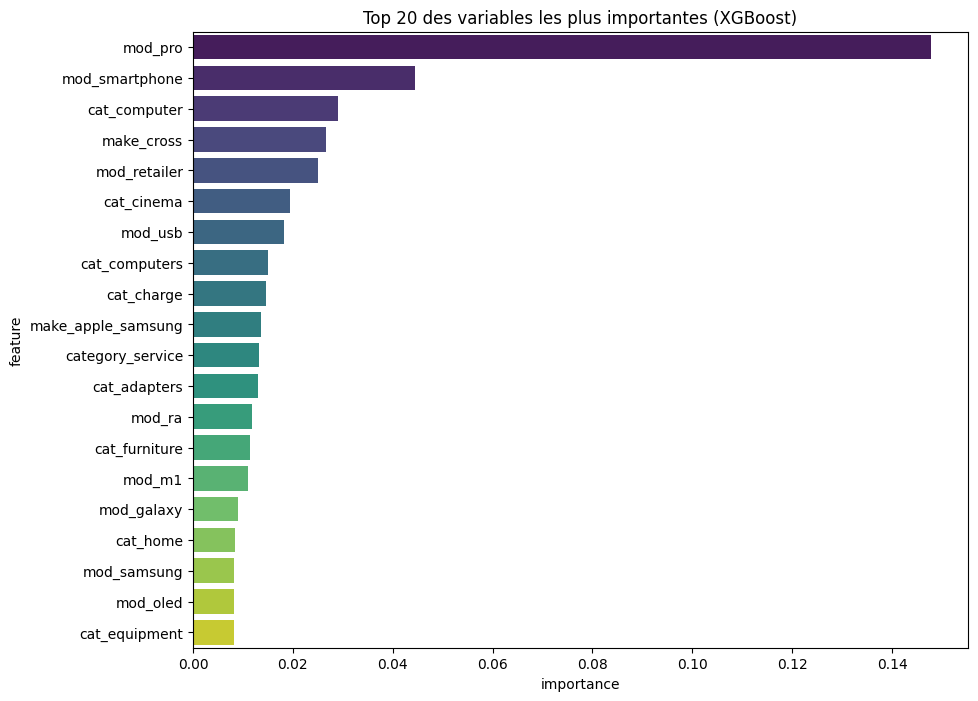

Suppression des variables inutiles.
Nouvelle taille du dataset : (92790, 249)
Ré-entraînement du Quatuor sur dataset nettoyé.
Fichier 'submission_6.csv' généré avec sélection de variables.


In [17]:
# 1. On récupère les importances de ton modèle XGBoost (le "chef")
importances = model.feature_importances_
feature_names = X.columns

# 2. On crée un DataFrame pour voir ça proprement
df_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# 3. Combien de variables ont une importance de 0 ?
zero_importance_features = df_importance[df_importance['importance'] == 0]['feature'].tolist()

print(f"Nombre total de variables : {len(feature_names)}")
print(f"Variables utilisées (importance > 0) : {len(feature_names) - len(zero_importance_features)}")
print(f"Variables inutiles (importance = 0) : {len(zero_importance_features)}")

print("\nExemple de variables inutiles (à supprimer) :")
print(zero_importance_features[:10])

# 4. Affichage du top 20
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=df_importance.head(20), palette='viridis')
plt.title('Top 20 des variables les plus importantes (XGBoost)')
plt.show()

# ==============================================================================
# APPLICATION DE LA SÉLECTION
# ==============================================================================

# Si on a beaucoup de variables inutiles, on les supprime pour ré-entraîner propre
if len(zero_importance_features) > 0:
    print("Suppression des variables inutiles.")
    
    # On réduit X et X_test_submit
    X_reduced = X.drop(columns=zero_importance_features)
    X_test_reduced = X_test_submit.drop(columns=zero_importance_features)
    
    # On doit aussi nettoyer X_lgb pour LightGBM
    X_lgb_reduced = X_reduced.copy()
    X_test_lgb_reduced = X_test_reduced.copy()
    X_lgb_reduced.columns = [re.sub(r'[^\w]', '_', col) for col in X_lgb_reduced.columns]
    X_test_lgb_reduced.columns = [re.sub(r'[^\w]', '_', col) for col in X_test_lgb_reduced.columns]

    print(f"Nouvelle taille du dataset : {X_reduced.shape}")
    
    # --- IL FAUT MAINTENANT RELANCER LES MODÈLES SUR CE DATASET RÉDUIT ---
    # Je te remets le code condensé pour relancer le Quatuor rapidement
    
    print("Ré-entraînement du Quatuor sur dataset nettoyé.")
    
    # 1. XGBoost
    model_xgb_clean = xgb.XGBClassifier(n_estimators=700, learning_rate=0.05, max_depth=5, scale_pos_weight=ratio, random_state=42, n_jobs=-1)
    model_xgb_clean.fit(X_reduced, y)
    p_xgb = model_xgb_clean.predict_proba(X_test_reduced)[:, 1]
    
    # 2. Random Forest
    model_rf_clean = RandomForestClassifier(n_estimators=300, max_depth=15, class_weight='balanced', n_jobs=-1, random_state=42)
    model_rf_clean.fit(X_reduced, y)
    p_rf = model_rf_clean.predict_proba(X_test_reduced)[:, 1]
    
    # 3. LightGBM
    model_lgb_clean = lgb.LGBMClassifier(n_estimators=500, learning_rate=0.03, num_leaves=31, class_weight='balanced', random_state=42, n_jobs=-1, verbose=-1)
    model_lgb_clean.fit(X_lgb_reduced, y)
    p_lgb = model_lgb_clean.predict_proba(X_test_lgb_reduced)[:, 1]
    
    # 4. CatBoost
    model_cat_clean = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=6, auto_class_weights='Balanced', random_seed=42, verbose=0)
    model_cat_clean.fit(X_reduced, y)
    p_cat = model_cat_clean.predict_proba(X_test_reduced)[:, 1]
    
    # Fusion
    final_probs_clean = (0.35 * p_xgb) + (0.25 * p_lgb) + (0.25 * p_cat) + (0.15 * p_rf)
    
    # Génération Fichier
    dict_preds_clean = dict(zip(df_test_ready.index, final_probs_clean))
    df_sub_clean = pd.read_csv('data/X_test_8skS2ey.csv', usecols=['ID'])
    df_sub_clean['fraud_flag'] = df_sub_clean['ID'].map(dict_preds_clean).fillna(0)
    df_sub_clean.index.name = 'index'
    df_sub_clean.to_csv('submission_6.csv', index=True)
    
    print("Fichier 'submission_6.csv' généré avec sélection de variables.")

else:
    print("Toutes les variables sont utiles, rien à supprimer.")

**Résultat avec sélection de variables**

On passe à un score de 0,1923.